# **주요 내용**

*   dev : 영어 (4,000), test : 한국어 (1,000)

In [1]:
notebookName = "20200528_5"
notebookName

'20200528_5'

In [2]:
import tensorflow as tf
tf.__version__

'2.2.0'

In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8593361141546275038, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 15260647980444367833
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 516446560403937714
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15701463552
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 3610147536224983943
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

In [4]:
import platform
platform.platform()

'Linux-4.19.104+-x86_64-with-Ubuntu-18.04-bionic'

In [5]:
!nvidia-smi

Thu May 28 10:26:25 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    31W / 250W |    353MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## **Unzip & Format Change**

In [0]:
import os

kor_pcm_path = "./kor_pcm_dataset"
kor_wav_path = "./kor_wav_dataset"

eng_pcm_path = "./eng_pcm_dataset"
eng_wav_path = "./eng_wav_dataset"

# mkdir
if not os.path.exists(kor_pcm_path): os.mkdir(kor_pcm_path)
if not os.path.exists(kor_wav_path): os.mkdir(kor_wav_path)

if not os.path.exists(eng_pcm_path): os.mkdir(eng_pcm_path)
if not os.path.exists(eng_wav_path): os.mkdir(eng_wav_path)

# unsip
!unzip -q "/content/drive/My Drive/ETRI/9_voice_download_4_Korean_English_by_Korean_part2.zip" -d "./kor_pcm_dataset"
!unzip -q "/content/drive/My Drive/ETRI/8_voice_download_4_Korean_English_by_Korean_part1.zip" -d "./eng_pcm_dataset"

In [8]:
print(os.listdir(kor_pcm_path)[:5], len(os.listdir(kor_pcm_path)))
print(os.listdir(eng_pcm_path)[:5], len(os.listdir(eng_pcm_path)))

['GSM03823YJK0', 'GSM05953CJH0', 'I4F07443LJA0', 'GSM09644KCK0', 'GSM03224CHD0'] 50
['GSM03823YJK0', 'GSM05953CJH0', 'I4F07443LJA0', 'GSM09644KCK0', 'GSM03224CHD0'] 50


In [0]:
import wave

kor_labels = dict()
eng_labels = dict()

for pcm_path, wav_path in zip([kor_pcm_path, eng_pcm_path], [kor_wav_path, eng_wav_path]):
    tmp_dict = dict()

    for i, folder_path in enumerate(sorted(os.listdir(pcm_path))):
        tmp_dict[folder_path] = i

        file_list = os.listdir(os.path.join(pcm_path, folder_path)) # label's path
        file_list_pcm = [files for files in file_list if files.endswith(".pcm")] # *.pcm files

        for j, file_path in enumerate(sorted(file_list_pcm)):
            with open(os.path.join(pcm_path, folder_path, file_path), "rb") as pcm_file:
                pcm_data = pcm_file.read()
            # save as {label}_{features}.wav format
            with wave.open(os.path.join(wav_path, "{}_{}.wav".format(i, j)), 'wb') as wav_file:
                wav_file.setparams((1, 2, 16000, 0, 'NONE', 'NONE')) # 16kHz, mono channel
                wav_file.writeframes(pcm_data)

    # save labeling pairs
    if pcm_path == kor_pcm_path: 
        kor_labels = tmp_dict
    else:
        eng_labels = tmp_dict

In [10]:
# Check that two groups are equal
set(kor_labels.keys()) == set(eng_labels.keys())

True

In [11]:
# Check that the order of two groups are equal
list(kor_labels.keys()) == list(eng_labels.keys())

True

In [0]:
import numpy as np

num_labels = 50
num_features = 100
data_length = 3 ** 9

train_rate = 0.8
num_train_data = int(num_features * train_rate) # 80

select_train_data = [True] * num_train_data + [False] * (num_features - num_train_data)
select_test_data = [False] * num_train_data + [True] * (num_features - num_train_data)

## **Split Train Data, Test Data**

In [13]:
from scipy.io import wavfile

kor_data = np.zeros((num_labels * num_features, data_length))
kor_labels = np.zeros((num_labels * num_features))

for i in range(num_labels):
    for j in range(num_features):
        file_name = "{}_{}.wav".format(i, j)
        sample_rate, samples = wavfile.read(os.path.join(kor_wav_path, file_name))
        
        start = int(len(samples) - data_length) // 2
        end = start + data_length
        
        kor_data[i * num_features + j] = samples[start:end]
        kor_labels[i * num_features + j] = i

kor_train_data = kor_data[select_train_data * num_labels]
kor_train_labels = kor_labels[select_train_data * num_labels]

kor_test_data = kor_data[select_test_data * num_labels]
kor_test_labels = kor_labels[select_test_data * num_labels]

# save *.npy        
np.save("./kor_train_data", kor_train_data)
np.save("./kor_train_labels", kor_train_labels)

np.save("./kor_test_data", kor_test_data)
np.save("./kor_test_labels", kor_test_labels)

print("kor_train_data.shape: {}, kor_train_labels.shape: {}".format(kor_train_data.shape, kor_train_labels.shape))
print("kor_test_data.shape: {}, kor_test_labels.shape: {}".format(kor_test_data.shape, kor_test_labels.shape))

kor_train_data.shape: (4000, 19683), kor_train_labels.shape: (4000,)
kor_test_data.shape: (1000, 19683), kor_test_labels.shape: (1000,)


In [14]:
from scipy.io import wavfile

eng_data = np.zeros((num_labels * num_features, data_length))
eng_labels = np.zeros((num_labels * num_features))

for i in range(num_labels):
    for j in range(num_features):
        file_name = "{}_{}.wav".format(i, j)
        sample_rate, samples = wavfile.read(os.path.join(eng_wav_path, file_name))
        
        start = int(len(samples) - data_length) // 2
        end = start + data_length
        
        eng_data[i * num_features + j] = samples[start:end]
        eng_labels[i * num_features + j] = i

eng_train_data = eng_data[select_train_data * num_labels]
eng_train_labels = eng_labels[select_train_data * num_labels]

eng_test_data = eng_data[select_test_data * num_labels]
eng_test_labels = eng_labels[select_test_data * num_labels]

# save *.npy        
np.save("./eng_train_data", eng_train_data)
np.save("./eng_train_labels", eng_train_labels)

np.save("./eng_test_data", eng_test_data)
np.save("./eng_test_labels", eng_test_labels)

print("eng_train_data.shape: {}, eng_train_labels.shape: {}".format(eng_train_data.shape, eng_train_labels.shape))
print("eng_test_data.shape: {}, eng_test_labels.shape: {}".format(eng_test_data.shape, eng_test_labels.shape))

eng_train_data.shape: (4000, 19683), eng_train_labels.shape: (4000,)
eng_test_data.shape: (1000, 19683), eng_test_labels.shape: (1000,)


## **Build Model**

In [0]:
# from tensorflow.keras.utils import plot_model

def build_model(model_name):
    model_input = tf.keras.layers.Input((data_length, 1))

    x = tf.keras.layers.Conv1D(name = "block1_conv", filters = 32, kernel_size = 3, padding = 'same', activation = 'relu')(model_input)
    x = tf.keras.layers.BatchNormalization(name = "block1_bn")(x)
    x = tf.keras.layers.MaxPooling1D(name = "block1_pool", pool_size = 3)(x)
    x = tf.keras.layers.Dropout(name = "block1_dropout", rate = 0.3)(x)

    x = tf.keras.layers.Conv1D(name = "block2_conv", filters = 64, kernel_size = 3, padding = 'same', activation = 'relu')(x)
    x = tf.keras.layers.BatchNormalization(name = "block2_bn")(x)
    x = tf.keras.layers.MaxPooling1D(name = "block2_pool", pool_size = 3)(x)
    x = tf.keras.layers.Dropout(name = "block2_dropout", rate = 0.3)(x)

    x = tf.keras.layers.Conv1D(name = "block3_conv", filters = 128, kernel_size = 3, padding = 'same', activation = 'relu')(x)
    x = tf.keras.layers.BatchNormalization(name = "block3_bn")(x)
    x = tf.keras.layers.MaxPooling1D(name = "block3_pool", pool_size = 3)(x)
    x = tf.keras.layers.Dropout(name = "block3_dropout", rate = 0.3)(x)

    x = tf.keras.layers.Conv1D(name = "block4_conv", filters = 256, kernel_size = 3, padding = 'same', activation = 'relu')(x)
    x = tf.keras.layers.BatchNormalization(name = "block4_bn")(x)
    x = tf.keras.layers.MaxPooling1D(name = "block4_pool", pool_size = 3)(x)
    x = tf.keras.layers.Dropout(name = "block4_dropout", rate = 0.3)(x)

    x = tf.keras.layers.GlobalAveragePooling1D(name = "avg_pool")(x)
    x = tf.keras.layers.Dense(name = "dense", units = 256, activation = None)(x)
    out = tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis = 1), name = "l2_norm_embedding")(x) # L2 normalize embeddings

    model = tf.keras.models.Model(inputs = model_input, outputs = out, name = model_name)
    model.summary()
    # plot_model(model, show_shapes = True, to_file = 'model.png')

    return model

## **Compile and Train model**

In [0]:
import tensorflow_addons as tfa

# callback
def scheduler(epoch, lr):
    # lr = 0.3 * lr for every 50 epochs
    if not epoch:
        return lr
    return 0.3 * lr if not (epoch % 50) else lr

def compile_and_train_model(model):
    model.compile(
        optimizer = tf.keras.optimizers.Adam(0.01),
        loss = tfa.losses.TripletSemiHardLoss())

    # Train the network
    history = model.fit(
        train_dataset,
        verbose = 1,
        epochs = 200,
        callbacks = [tf.keras.callbacks.LearningRateScheduler(scheduler)])

    return history

In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices((eng_train_data[:, :, np.newaxis], eng_train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((kor_test_data[:, :, np.newaxis], kor_test_labels))

train_dataset = train_dataset.shuffle(buffer_size = data_length * 128 * 10).batch(128)
test_dataset = test_dataset.batch(128)

In [18]:
train_dataset

<BatchDataset shapes: ((None, 19683, 1), (None,)), types: (tf.float64, tf.float64)>

In [19]:
train_eng_test_kor_model = build_model("train_eng_test_kor")

Model: "train_eng_test_kor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 19683, 1)]        0         
_________________________________________________________________
block1_conv (Conv1D)         (None, 19683, 32)         128       
_________________________________________________________________
block1_bn (BatchNormalizatio (None, 19683, 32)         128       
_________________________________________________________________
block1_pool (MaxPooling1D)   (None, 6561, 32)          0         
_________________________________________________________________
block1_dropout (Dropout)     (None, 6561, 32)          0         
_________________________________________________________________
block2_conv (Conv1D)         (None, 6561, 64)          6208      
_________________________________________________________________
block2_bn (BatchNormalizatio (None, 6561, 64)   

In [20]:
train_eng_test_kor_model_history = compile_and_train_model(train_eng_test_kor_model)

Epoch 1/200
32/32 [==============================] - 4s 136ms/step - loss: 0.9705 - lr: 0.0100
Epoch 2/200
32/32 [==============================] - 4s 136ms/step - loss: 0.9453 - lr: 0.0100
Epoch 3/200
32/32 [==============================] - 4s 137ms/step - loss: 0.9219 - lr: 0.0100
Epoch 4/200
32/32 [==============================] - 4s 136ms/step - loss: 0.9014 - lr: 0.0100
Epoch 5/200
32/32 [==============================] - 4s 136ms/step - loss: 0.8791 - lr: 0.0100
Epoch 6/200
32/32 [==============================] - 4s 136ms/step - loss: 0.8587 - lr: 0.0100
Epoch 7/200
32/32 [==============================] - 4s 136ms/step - loss: 0.8322 - lr: 0.0100
Epoch 8/200
32/32 [==============================] - 4s 136ms/step - loss: 0.8104 - lr: 0.0100
Epoch 9/200
32/32 [==============================] - 4s 136ms/step - loss: 0.7733 - lr: 0.0100
Epoch 10/200
32/32 [==============================] - 4s 137ms/step - loss: 0.7451 - lr: 0.0100
Epoch 11/200
32/32 [=============================

In [21]:
train_eng_test_kor_model_history.history.keys()

dict_keys(['loss', 'lr'])

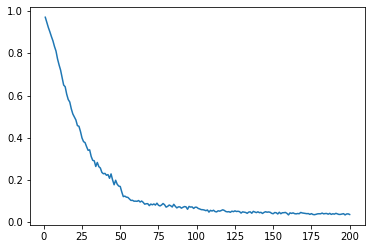

In [33]:
from matplotlib import pyplot as plt
plt.plot(np.arange(1, 200 + 1, 1), train_eng_test_kor_model_history.history['loss'])

## **Calculate Performance Evaluation Metrics (of test dataset)**
*   True Positive Rate (TPR)
*   False Positive Rate (FPR)
*   Equal Error Rate (EER)

In [0]:
test_pred = train_eng_test_kor_model.predict(test_dataset)
# test_true = test_labels

In [0]:
import itertools

true_accept = np.zeros((0), dtype = float)
false_accept = np.zeros((0), dtype = float)

for i in range(num_labels):
    same_class = test_pred[np.where(kor_test_labels == i)]
    diff_class = test_pred[np.where(kor_test_labels != i)]

    partial_true_accept = tf.norm([i[0] - i[1] for i in np.array(list(itertools.permutations(same_class, 2)))], axis = -1)
    partial_false_accept = tf.norm([i - j for i in same_class for j in diff_class], axis = -1)

    true_accept = np.concatenate([true_accept, partial_true_accept.numpy()], axis = None)
    false_accept = np.concatenate([false_accept, partial_false_accept.numpy()], axis = None)

In [25]:
print("true_accept.shape: {}".format(true_accept.shape))    # (80 P 2) * 50 = 19,000
print("false_accept.shape: {}".format(false_accept.shape)) # (80 * 3920) * 50 = 980,000

true_accept.shape: (19000,)
false_accept.shape: (980000,)


In [0]:
tpr = np.zeros((10 ** 4), dtype = float)
fpr = np.zeros((10 ** 4), dtype = float)

total_results = np.concatenate([true_accept, false_accept], axis = None)

# Strictly, below comparisons can be performed with all possible d values in total_results.
# E.g. for i, d in enumerate(np.sort(np.concatenate([true_accept, false_accept], axis = None))):
for i, d in enumerate(np.linspace(np.min(total_results), np.max(total_results), 10 ** 4)):    
    tpr[i] = np.where(true_accept <= d)[0].shape[0]
    fpr[i] = np.where(false_accept <= d)[0].shape[0]

In [0]:
tpr = tpr / len(true_accept)
fpr = fpr / len(false_accept)

In [28]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.layouts import gridplot
from bokeh.io import export_png
from bokeh.colors import RGB

output_notebook()

p = figure(width = 400, height = 400, title = "False Potivie Rate and False Negative Rate")

p.line(
    np.linspace(0, 1, 10 ** 4), fpr,
    color = "firebrick",
    legend_label ='False Positive Rate',
    line_width = 2
)

p.line(
    np.linspace(0, 1, 10 ** 4), 1 - tpr,
    color = "cornflowerblue",
    legend_label ='False Negative Rate',
    line_width = 2,
    line_dash = (5, 3)
)

p.legend.location = "top_center"

show(p)

In [29]:
p = figure(
    width = 400, height = 400, title = "Receiver Operating Characteristic Curve",
    x_axis_type = "log")

p.line(
    fpr, tpr,
    color = "firebrick",
    legend_label ='Our Model',
    line_width = 2)

# p.line(
#     np.linspace(0, 1, 10 ** 4), np.linspace(0, 1, 10 ** 4),
#     color = "lightgray",
#     legend_label ='Truely Random',
#     line_width = 2,
#     line_dash = (5, 3))

p.xaxis.axis_label = 'False Positive Rate'
p.yaxis.axis_label = 'True Positive Rate'
p.legend.location = "bottom_right"

show(p)

In [30]:
from scipy.optimize import brentq
from scipy.interpolate import interp1d

eer = brentq(lambda x: 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
print("Equal Error Rate: {:.4f}".format(eer))

Equal Error Rate: 0.0518


In [0]:
# Save tpr, fpr
_path = os.path.join("/content/drive/My Drive/results", notebookName)
if not os.path.exists(_path): 
    os.mkdir(_path)

np.savez_compressed(
    os.path.join(_path, notebookName),
    tpr = tpr,
    fpr = fpr
)

## **Embedding Visualization with t-Stochastic Neighbor Embedding (t-SNE)**

*   https://lovit.github.io/nlp/representation/2018/09/28/tsne/
*   https://lovit.github.io/nlp/representation/2018/09/28/tsne/


In [0]:
import numpy as np

n_data_per_class = num_train_data
n_classes = num_labels

x = train_eng_test_kor_model.predict(test_dataset)
y = eng_test_labels

In [35]:
x.shape

(1000, 256)

In [36]:
y.shape

(1000,)

In [37]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.layouts import gridplot
from bokeh.io import export_png
from bokeh.colors import RGB

output_notebook()

title = '{} classes {} points'.format(n_classes, n_classes * n_data_per_class)

def draw_figure(x, y, title, show_figure=True):
    # colors = 'firebrick darksalmon lightslategray darkslateblue forestgreen'.split()):

    p = figure(width = 400, height = 400, title = title)
    for c in range(n_classes):
        idx = np.where(y == c)[0]
        x_ = x[idx]
        c = RGB(
            np.random.randint(0, 256),
            np.random.randint(0, 256),
            np.random.randint(0, 256)
        )
        p.scatter(x_[:,0], x_[:,1], fill_color = c, line_color = c)
    if show_figure:
        show(p)
    return p

p = draw_figure(x, y, title)

In [38]:
# Predict test_set
from sklearn.manifold import TSNE

plots = []
for perplexity in [2, 5, 10, 30, 100, 200, 500, 1000]:
    z = TSNE(
        n_components = 2,
        perplexity = perplexity
    ).fit_transform(x)
    title = 't-SNE with perplexity = {}'.format(perplexity)
    plots.append(draw_figure(z, y, title, show_figure = False))

gp = gridplot([
               [plots[0], plots[1]],
               [plots[2], plots[3]], 
               [plots[4], plots[5]],
               [plots[6], plots[7]]])
show(gp)

## **K-Nearest Neighbor Algorithm**

In [0]:
from sklearn.neighbors import KNeighborsClassifier

x = model.predict(train_dataset)
# x = TSNE(n_components = 2).fit_transform(model.predict(train_dataset))
y = train_labels

classifier = KNeighborsClassifier(n_neighbors = 3, weights = 'distance')
classifier.fit(x, y)

In [0]:
_x = model.predict(test_dataset)
# _x = TSNE(n_components = 2).fit_transform(model.predict(test_dataset))
_y = test_labels

print(classifier.score(_x, _y))

In [0]:
model.predict(train_dataset).shape